In [ ]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE
import geopandas as gpd
import pickle
import matplotlib as mpl
import math
import random


def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn


 #----------------
# parameters
#----------------
S = 32
N = 1000
lmbda = 1000
nu = 0.02
num_samples = 225 # 225 #  400 # 400 # 400 # 200
R =  3 # 3 # 3 # 3 # 5
num_gpus = 1
num_cpus = 2


# get directory above
main_dir = "/home/dvdijcke/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out') 

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'


import random
random.seed(9910)

## Mobile

In [ ]:
gdf

,count,count_before,count_norm,geometry,count_scaled
0,0.0,0,0.0,"POLYGON ((7649981.161 2531547.755, 7654981.161...",0.0
1,0.0,0,0.0,"POLYGON ((7654981.161 2531547.755, 7659981.161...",0.0
2,0.0,0,0.0,"POLYGON ((7659981.161 2531547.755, 7664981.161...",0.0
3,0.0,0,0.0,"POLYGON ((7659981.161 2536547.755, 7664981.161...",0.0
4,0.0,0,0.0,"POLYGON ((7654981.161 2536547.755, 7659981.161...",0.0
...,...,...,...,...,...
60001,0.0,0,0.0,"POLYGON ((9009981.161 2536547.755, 9014981.161...",0.0
60002,0.0,0,0.0,"POLYGON ((9004981.161 2536547.755, 9009981.161...",0.0
60003,0.0,6,0.0,"POLYGON ((9004981.161 2531547.755, 9009981.161...",0.0
60004,0.0,0,0.0,"POLYGON ((9009981.161 2531547.755, 9014981.161...",0.0


In [ ]:

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_grid.geojson')
gdf = gpd.read_file(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['count_norm'] = gdf['count_norm'] * 100
gdf['count_norm'] = np.where(gdf['count_before'] == 0, 100, gdf['count_norm'])
print(gdf.head())
Y = np.array(gdf['count_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.95)
Y[Y>qtile] = qtile


   count  count_before  count_norm  \
0    0.0             0       100.0   
1    0.0             0       100.0   
2    0.0             0       100.0   
3    0.0             0       100.0   
4    0.0             0       100.0   

                                            geometry  
0  POLYGON ((7649981.161 2531547.755, 7654981.161...  
1  POLYGON ((7654981.161 2531547.755, 7659981.161...  
2  POLYGON ((7659981.161 2531547.755, 7664981.161...  
3  POLYGON ((7659981.161 2536547.755, 7664981.161...  
4  POLYGON ((7654981.161 2536547.755, 7659981.161...  


In [18]:
# get SURE parameters
fto = os.path.join(data_out, 'india_mobile_SURE_95_025_lambda100_nu01.pkl') 	# india_mobile_SURE_95_025_lambda100.pkl
with open(fto, "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']

In [19]:
print(lmbda, nu)

89.56324846072415 0.02679312561036402


In [ ]:
resolution = 1/int(np.sqrt(0.25*Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 50000, tol = 1e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [ ]:
# model.lmbda = 100
# model.nu = 0.02

In [ ]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


Execution time: 150.35 seconds


In [ ]:
J_grid = results['J']
u = results['u']

In [ ]:
# average in shutdown area
(u[0:20,20:40]*3).mean()

278.46519513123525

In [ ]:
# average elsewhere
np.quantile((u[u*3 > 80]*3),0.5)

218.90236601992183

/tmp/ipykernel_3053799/384591430.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


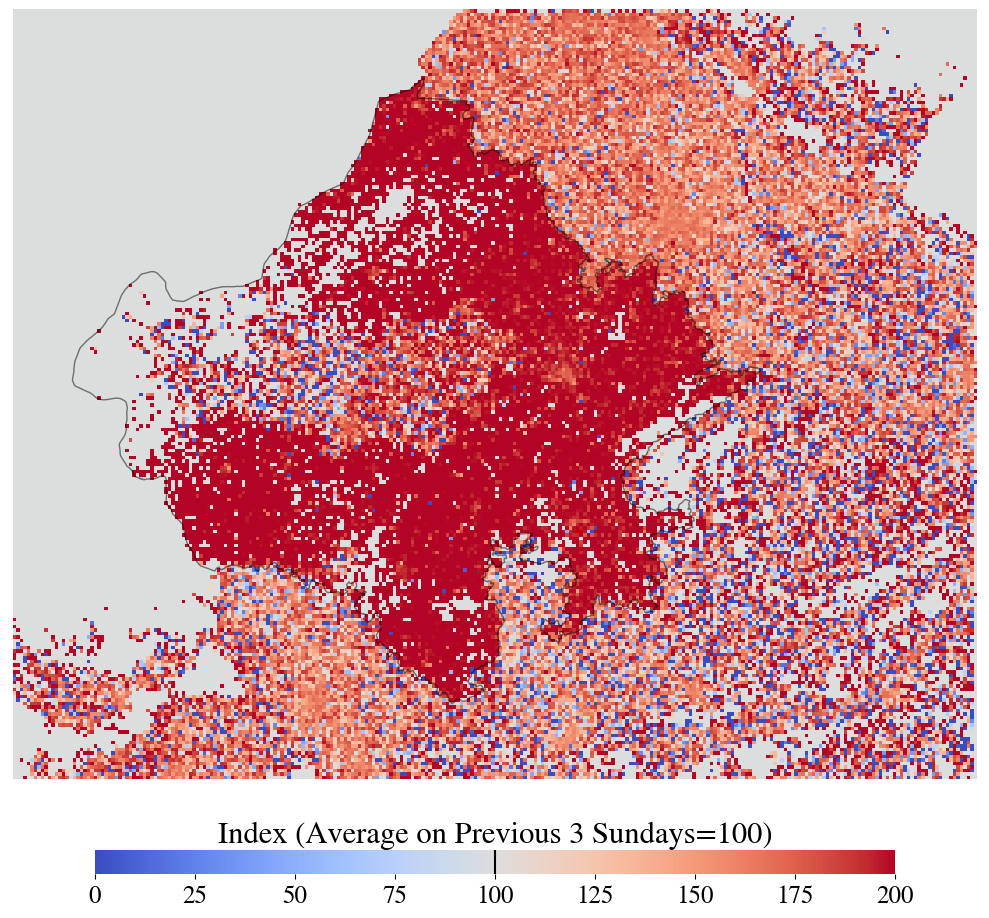

In [ ]:
from matplotlib.cm import ScalarMappable

gdf['count_scaled'] = gdf['count_norm'] * 3
# Load the shapefile data
states_gdf = gpd.read_file(os.path.join(data_in, 'india', 'india_states_shapefile'))

# Convert the CRS of the states GeoDataFrame to match the CRS of the Rajasthan GeoDataFrame
states_gdf = states_gdf.to_crs(gdf.crs)


# Extract the geometry for Rajasthan
rajasthan_geometry = states_gdf[states_gdf['name_1'] == 'Rajasthan']['geometry']

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the data
vmax = 200
im = gdf.plot(column="count_norm", cmap='coolwarm_r', vmin=0, vmax=vmax, ax=ax)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=1, ax=ax, alpha=0.5)



# Create a mappable for colorbar using ScalarMappable
norm = plt.Normalize(vmin=0, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([]) # Need to set_data with an empty array


# Position and add the colorbar
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=22, loc = "center")
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_visible(False)


# Remove padding and axis
ax.set_axis_off()
ax.set_rasterized(True)
ax.margins(0)
ax.axis("equal")


# Set the plot limits to match the defined zoom area
plt.tight_layout()


plt.savefig("india_gridy.pdf", bbox_inches="tight")

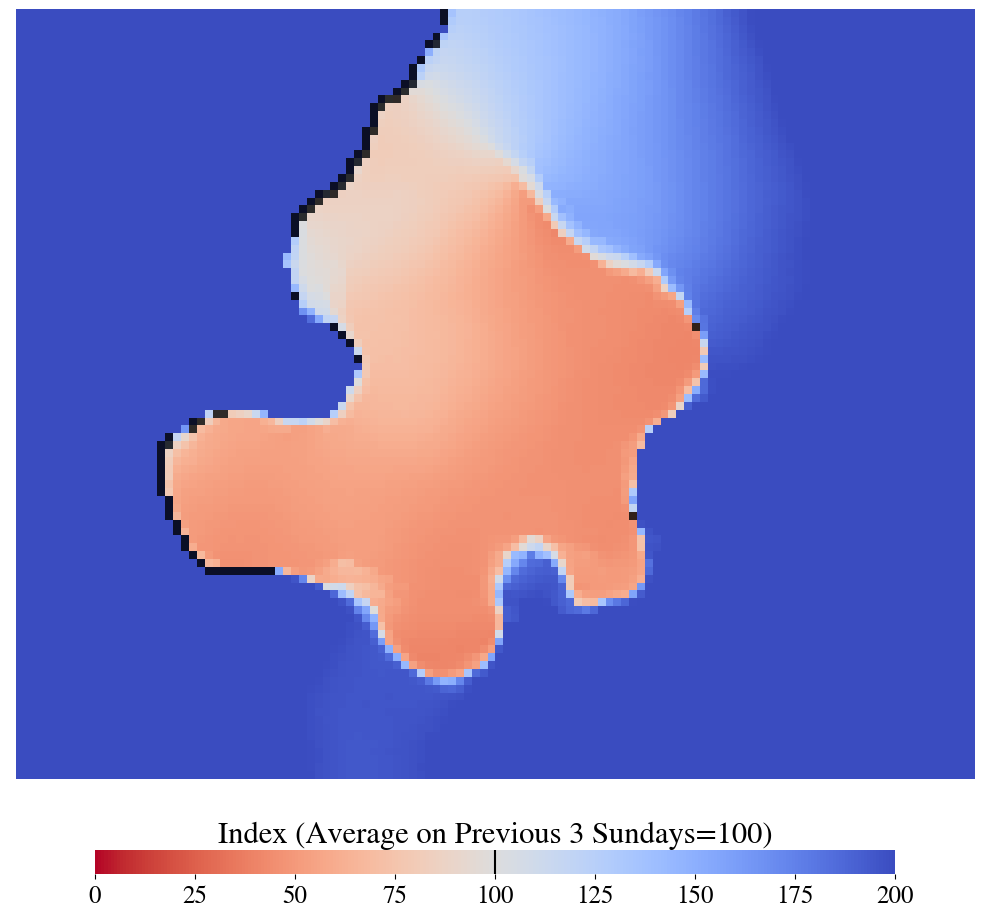

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = plt.imshow(u.T*3, cmap = "coolwarm_r", origin="lower", vmin=0, vmax=vmax,
               interpolation="none")
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_visible(False)



# Add a vertical line inside the colorbar at 100
cbar.ax.axvline(100, color='k')

J_temp = J_grid.copy()
J_temp = J_temp.astype(float)
J_temp[J_temp == 0] = np.nan
ax.imshow(J_temp.T, cmap = "binary_r", origin="lower", alpha=0.8)

plt.savefig("india_u.pdf", bbox_inches="tight")


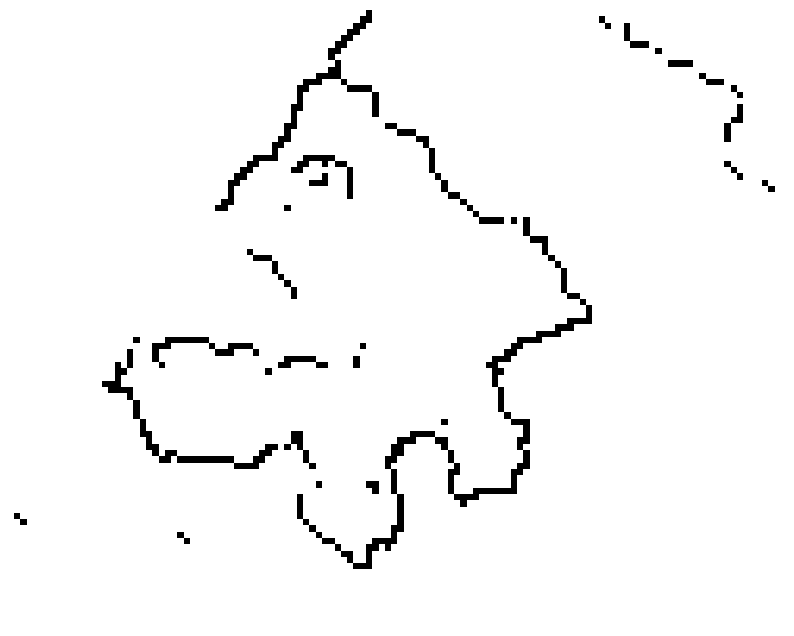

In [88]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

img = ax.imshow(J_grid.T, cmap = "binary", origin="lower")
ax.set_axis_off()
ax.axis("equal")
plt.savefig("india_Jgrid.pdf", bbox_inches="tight")

In [16]:
# plot treatment effect curve
jumps = model.boundaryGridToData(J_grid, u*3)
jumpdf = pd.DataFrame(jumps)

jumpdf['Y_jumpsize'] = jumpdf['Y_jumpsize'].abs()

Xplot = np.zeros(model.grid_x.shape[:-1])

for index,row in jumpdf.iterrows():
  Xplot[int(row['X_0'] / model.resolution), int(row['X_1'] / model.resolution)] = np.abs(row['Y_jumpsize'])
#Xplot = Xplot * 100

In [17]:
Xplot.shape

(122, 98)

In [18]:
# remove parts in the northeast
Xplot[(model.grid_x[...,1]*300 > 220) & (model.grid_x[...,0]*300 > 140)] = 0
Xplot[(model.grid_x[...,1]*300 < 75) & (model.grid_x[...,0]*300 < 63)] = 0
Xplot[(model.grid_x[...,0]*300 < 20)] = 0

In [19]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian filter
smoothed_parts = gaussian_filter(Xplot[Xplot != 0], sigma=1)
smoothed_Xplot = Xplot.copy()
smoothed_Xplot[Xplot != 0] = smoothed_parts

/tmp/ipykernel_4183464/1103508413.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


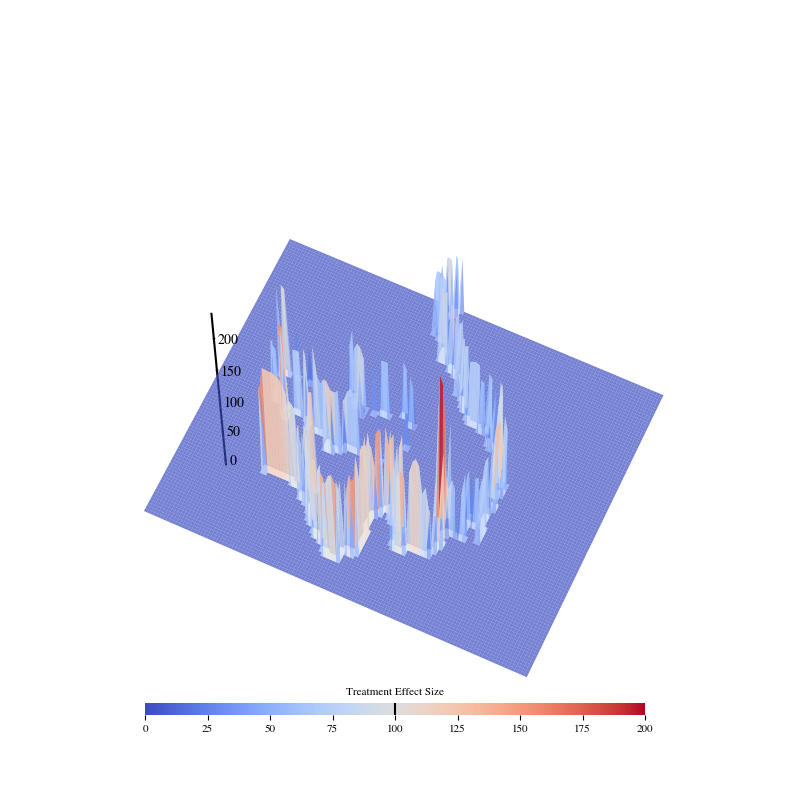

In [20]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cmap = plt.cm.coolwarm
lowest_color = cmap(0.0)
im = ax.plot_surface(model.grid_x[...,1]*300, model.grid_x[...,0]*300, Xplot, 
                rstride=1, cstride=1, antialiased=True, 
                cmap="coolwarm", edgecolor=(0,0,0,0), alpha=0.7)

# Set z-axis limits
zmin = 0
ax.set_zlim(bottom=zmin)

ax.set_axis_off()
ax.axis("equal")
ax.margins(0)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Draw the artificial z-axis. This example places it at the left front corner.
# You can adjust the X, Y coordinates as needed.
x_start, y_start = 35, 60
z_lim = ax.get_zlim()
ax.plot([x_start, x_start], [y_start, y_start], [z_lim[0], z_lim[1]], color='k')

cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.015])  # [left, bottom, width, height]
cbar_ax.set_title("Treatment Effect Size", fontsize=8, loc="center")
temp = Xplot.copy()
temp[temp>200] = 200
m = cm.ScalarMappable(cmap="coolwarm")
m.set_array(temp)
cbar = plt.colorbar(m, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=8)


# Label the z-axis
# ax.text(x_start, y_start, 1.1*z_lim[1], 'Index', fontsize=12)

# Add ticks to the artificial z-axis
number_of_ticks = 5
tick_length = 0.2
z_ticks = np.linspace(0, 200, number_of_ticks)
for z_tick in z_ticks:
    ax.plot([x_start, x_start + tick_length], [y_start, y_start], [z_tick, z_tick], color='k')
    ax.text(x_start + 15 * tick_length, y_start, z_tick, f"{z_tick:.0f}", verticalalignment='center')


# Set the view angle
ax.view_init(elev=65, azim=-65)
plt.tight_layout()

plt.savefig("india_treatmentcurve.pdf", bbox_inches="tight", dpi=300)

In [21]:
# store estimates for comparison to economic
print("Median " + str(np.quantile(Xplot[Xplot > 0], 0.5)), " mean: ", str(Xplot[Xplot > 0].mean()))

Median 106.23363862865878  mean:  112.13991751063104


### Plot conformal bands

In [22]:
X_smaller = model.grid_x.reshape(-1, model.grid_x.shape[-1])[:,::-1] * model.X_raw.max() + np.min(model.X_raw, axis = 0)
Y_smaller = model.grid_y.flatten() * model.Y_raw.max() + np.min(model.Y_raw)
model.X_raw, model.Y_raw, model.Y = X_smaller, Y_smaller, Y_smaller
model.N = Y_smaller.shape[0]

u_lower, u_upper, J_lower = model.conformalSplit()


/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


In [23]:
J_uc = model.conformalUncertainty(a_bins = 1000)

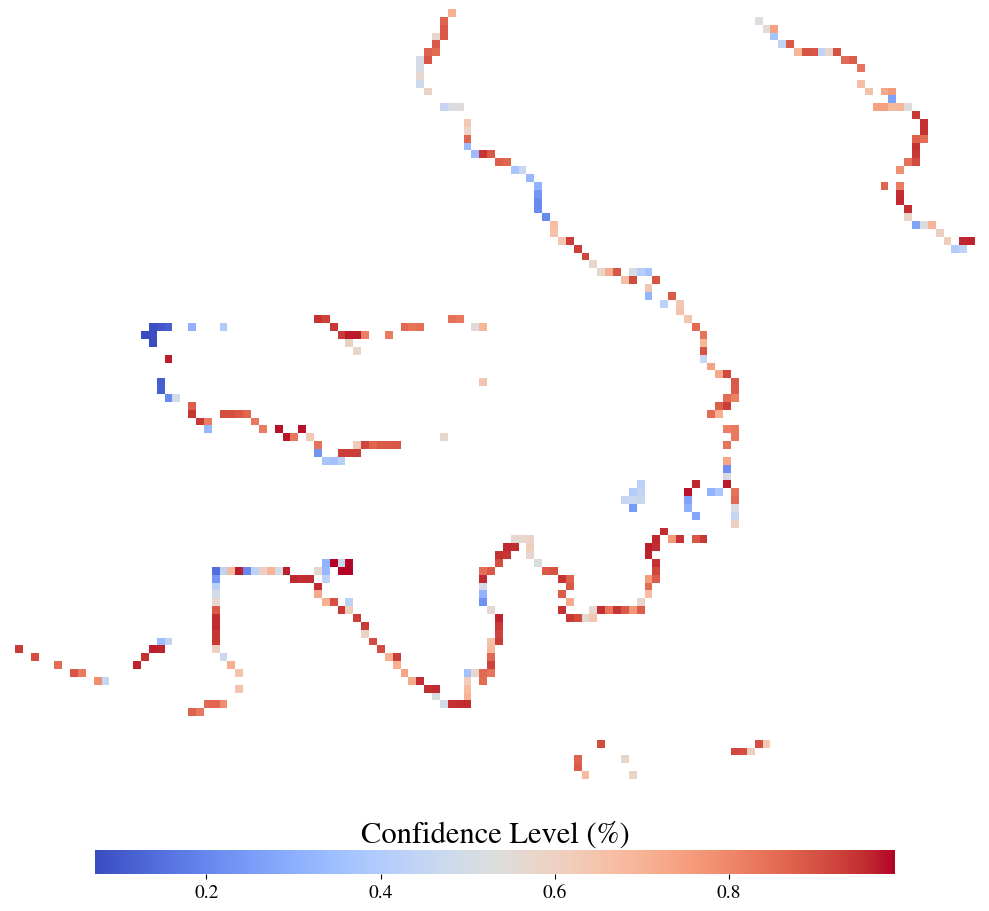

In [24]:
J_mult = J_grid.copy().astype(float)
J_mult[J_mult == 0] = np.nan
J_plot = J_uc * J_mult
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
vmin = (J_uc).min()
im = plt.imshow((J_plot).T  , cmap = "coolwarm", origin="lower", 
               interpolation="none", vmin = J_plot[~np.isnan(J_plot)].min())
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Confidence Level (%)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
# num_ticks = 12  # Replace this with the number of ticks you want
# cbar.locator = plt.MaxNLocator(num_ticks)
cbar.outline.set_visible(False)
plt.savefig("india_uncertainty_mobile.pdf", bbox_inches="tight", dpi=300)

In [25]:
mask = np.ones(J_plot.shape, dtype=bool)
mask.T[80:100, 90:120] = False

print("10% Sign. " + str((J_plot[mask] > 0.90).sum()  / (J_plot[mask] > 0).sum()) + "5% Sign. " + str((J_plot[mask] > 0.95).sum()  / (J_plot[mask] > 0).sum()))



10% Sign. 0.29117647058823535% Sign. 0.12058823529411765


## Economic

In [20]:

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_shops_merged_40K.geojson')
gdf = gpd.read_file(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['pings_share_norm'] = gdf['pings_share_norm'] * 100
print(gdf.head())
Y = np.array(gdf['pings_share_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.90)
Y[Y>qtile] = qtile
#Y = Y + 100 # needed because otherwise max is 0 and we scale by that

   pings        count  pings_before  count_before  pings_norm  pings_share  \
0  667.0  8716.000000    479.000000   8716.000000    1.392484     0.076526   
1    0.0  6224.666667      3.666667   6224.666667    0.000000     0.000000   
2    0.0     0.000000      0.000000      0.000000    0.000000     0.000000   
3   83.0  6593.000000    204.333333   6593.000000    0.406199     0.012589   
4    0.0  9156.666667      0.000000   9156.666667    0.000000     0.000000   

   pings_share_pre  pings_share_change  pings_share_norm  \
0         0.054956            0.021570         39.248434   
1         0.000589           -0.000589       -100.000000   
2         0.000000            0.000000          0.000000   
3         0.030992           -0.018403        -59.380098   
4         0.000000            0.000000          0.000000   

                                            geometry  
0  POLYGON ((7649892.743 2531408.573, 7689892.743...  
1  POLYGON ((7689892.743 2531408.573, 7729892.743...  
2  PO

In [21]:
# get SURE parameters
fto = os.path.join(data_out, 'india_econ_SURE_90_lambda10_nu1.pkl') 
with open(fto, "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']
print(lmbda, nu)

8.906514201329486 0.1023653377248418


In [22]:
# lmbda=10
# nu=0.11

In [23]:
resolution = 1/int(np.sqrt(Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 50000, tol = 5e-6, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [24]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


Execution time: 119.75 seconds


In [25]:
J_grid = results['J']
u = results['u']


/tmp/ipykernel_3053799/2151761103.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


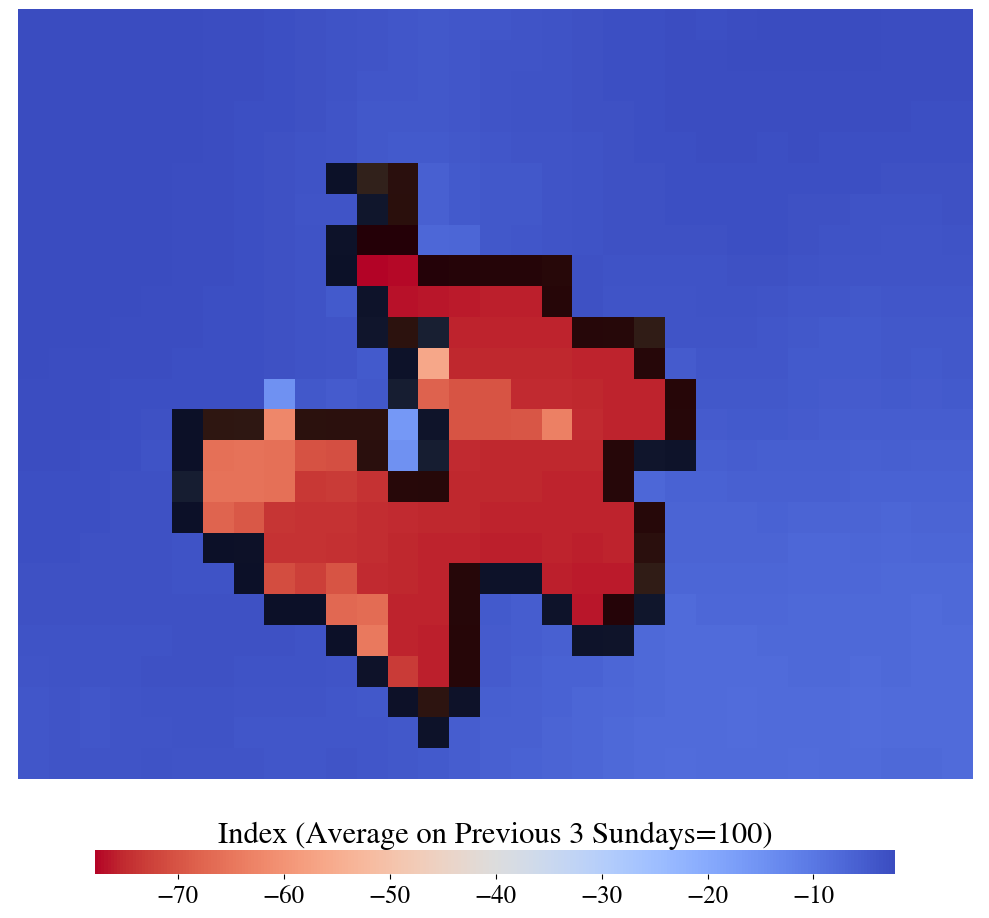

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = plt.imshow(u.T, cmap = "coolwarm_r", origin="lower",
               interpolation="none")
ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_visible(False)



# Add a vertical line inside the colorbar at 100
cbar.ax.axvline(100, color='k')

J_temp = J_grid.copy()
J_temp = J_temp.astype(float)
J_temp[J_temp == 0] = np.nan
ax.imshow(J_temp.T, cmap = "binary_r", origin="lower", alpha=0.8)

plt.tight_layout()

plt.savefig("india_econ_u.pdf", bbox_inches="tight", dpi=300)
np.save("u_econ", u) 

In [53]:
u.max()

-2.2986114838631124

### Raw data

/tmp/ipykernel_3053799/4279562454.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


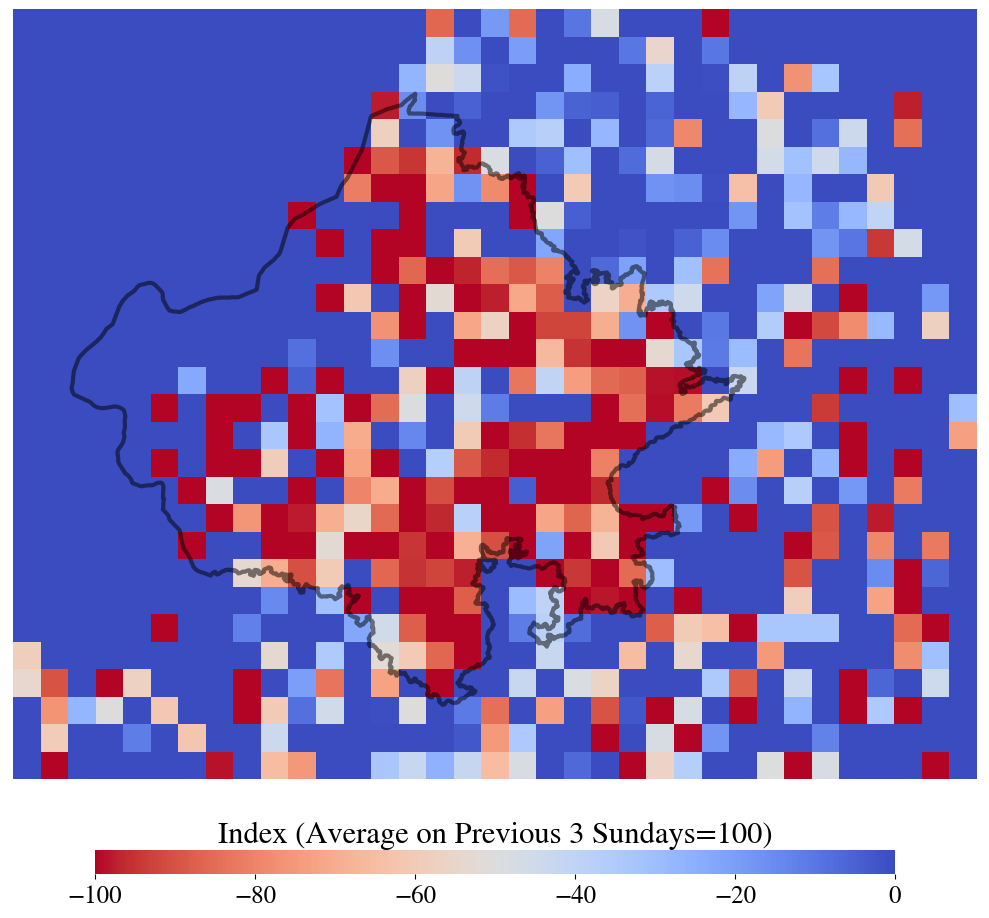

In [27]:
from matplotlib.cm import ScalarMappable

# Load the shapefile data
states_gdf = gpd.read_file(os.path.join(data_in, 'india', 'india_states_shapefile'))

# Convert the CRS of the states GeoDataFrame to match the CRS of the Rajasthan GeoDataFrame
states_gdf = states_gdf.to_crs(gdf.crs)


# Extract the geometry for Rajasthan
rajasthan_geometry = states_gdf[states_gdf['name_1'] == 'Rajasthan']['geometry']

# Reset the limits for the zoom (to show the entire Rajasthan)
rajasthan_extent = states_gdf[states_gdf['name_1'] == 'Rajasthan'].total_bounds
xlim = (rajasthan_extent[0], rajasthan_extent[2])
ylim = (rajasthan_extent[1], rajasthan_extent[3])

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the data
vmax = 200
im = gdf.plot(column="pings_share_norm", cmap='coolwarm_r', vmax=0, vmin=-100, ax=ax)

# Plot the Rajasthan border
rajasthan_geometry.boundary.plot(color='k', linewidth=3, ax=ax, alpha=0.5)



# Create a mappable for colorbar using ScalarMappable
norm = plt.Normalize(vmin=-100, vmax=0)
sm = ScalarMappable(norm=norm, cmap='coolwarm_r')
sm.set_array([]) # Need to set_data with an empty array


# Position and add the colorbar
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Index (Average on Previous 3 Sundays=100)", fontsize=22, loc = "center")
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_visible(False)


# Remove padding and axis
ax.set_axis_off()
ax.set_rasterized(True)
ax.margins(0)
ax.axis("equal")


# Set the plot limits to match the defined zoom area
plt.tight_layout()


plt.savefig("india_econ_gridy.pdf", bbox_inches="tight")

### Treatment curve

In [28]:
# plot treatment effect curve
jumps = model.boundaryGridToData(J_grid, u)
jumpdf = pd.DataFrame(jumps)

jumpdf['Y_jumpsize'] = jumpdf['Y_jumpsize'].abs()

Xplot = np.zeros(model.grid_x.shape[:-1])

for index,row in jumpdf.iterrows():
  Xplot[int(row['X_0'] / model.resolution), int(row['X_1'] / model.resolution)] = np.abs(row['Y_jumpsize'])
#Xplot = Xplot * 100

In [29]:
# remove parts in the northeast
Xplot[(model.grid_x[...,1]*300 > 220) & (model.grid_x[...,0]*300 > 140)] = 0
Xplot[(model.grid_x[...,1]*300 < 50) & (model.grid_x[...,0]*300 < 45)] = 0
Xplot[(model.grid_x[...,1]*300 > 240)] = 0
Xplot[(model.grid_x[...,0]*300 > 220)] = 0

/tmp/ipykernel_3053799/1977673363.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


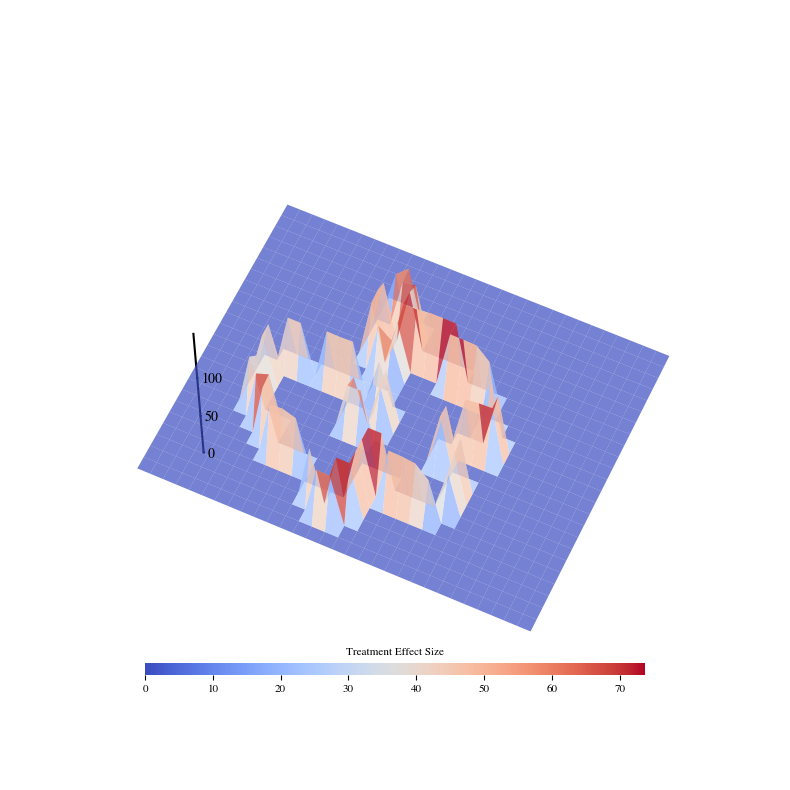

In [30]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


cmap = plt.cm.coolwarm
lowest_color = cmap(0.0)
im = ax.plot_surface(model.grid_x[...,1]*300, model.grid_x[...,0]*300, Xplot, 
                rstride=1, cstride=1, antialiased=True, 
                cmap="coolwarm", edgecolor=(0,0,0,0), alpha=0.7)

# Set z-axis limits
zmin = 0
ax.set_zlim(bottom=zmin)

ax.set_axis_off()
ax.axis("equal")
ax.margins(0)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Draw the artificial z-axis. This example places it at the left front corner.
# You can adjust the X, Y coordinates as needed.
x_start, y_start = 35, 30 # x_start, y_start = 35, 75
z_lim = ax.get_zlim()
ax.plot([x_start, x_start], [y_start, y_start], [0, z_lim[1]], color='k')

# Label the z-axis
# ax.text(x_start, y_start, 1.1*z_lim[1], 'Index', fontsize=12)

cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.015])  # [left, bottom, width, height]
cbar_ax.set_title("Treatment Effect Size", fontsize=8, loc="center")
m = cm.ScalarMappable(cmap="coolwarm")
m.set_array(Xplot)
cbar = plt.colorbar(m, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.ax.axvline(100, color='k')  # Add vertical line at 100
cbar.ax.tick_params(labelsize=8)

# Add ticks to the artificial z-axis
number_of_ticks = 3
tick_length = 0.2
z_ticks = np.linspace(0, 100, number_of_ticks)
for z_tick in z_ticks:
    ax.plot([x_start, x_start + tick_length], [y_start, y_start], [z_tick, z_tick], color='k')
    ax.text(x_start + 15 * tick_length, y_start, z_tick, f"{z_tick:.0f}", verticalalignment='center')


# Set the view angle
ax.view_init(elev=60, azim=-65)
plt.tight_layout()

plt.savefig("india_econ_treatmentcurve.pdf", bbox_inches="tight", dpi=300)




In [31]:
print("Median " + str(np.quantile(Xplot[(Xplot < 100) & (Xplot > 0)], 0.5)), " mean: ", str(Xplot[(Xplot > 0) & (Xplot < 100)].mean()))


Median 67.57212038737265  mean:  65.66271004195116


In [51]:
Xplot[Xplot>0].mean()

65.66271004195116

### Conformal inference

In [35]:
import random
random.seed(9910)
model.alpha = 0.05
u_lower, u_upper, J_lower = model.conformalSplit()
#u_lower, u_upper, J_lower = model.conformalSplitBounds(alpha=0.1)


/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


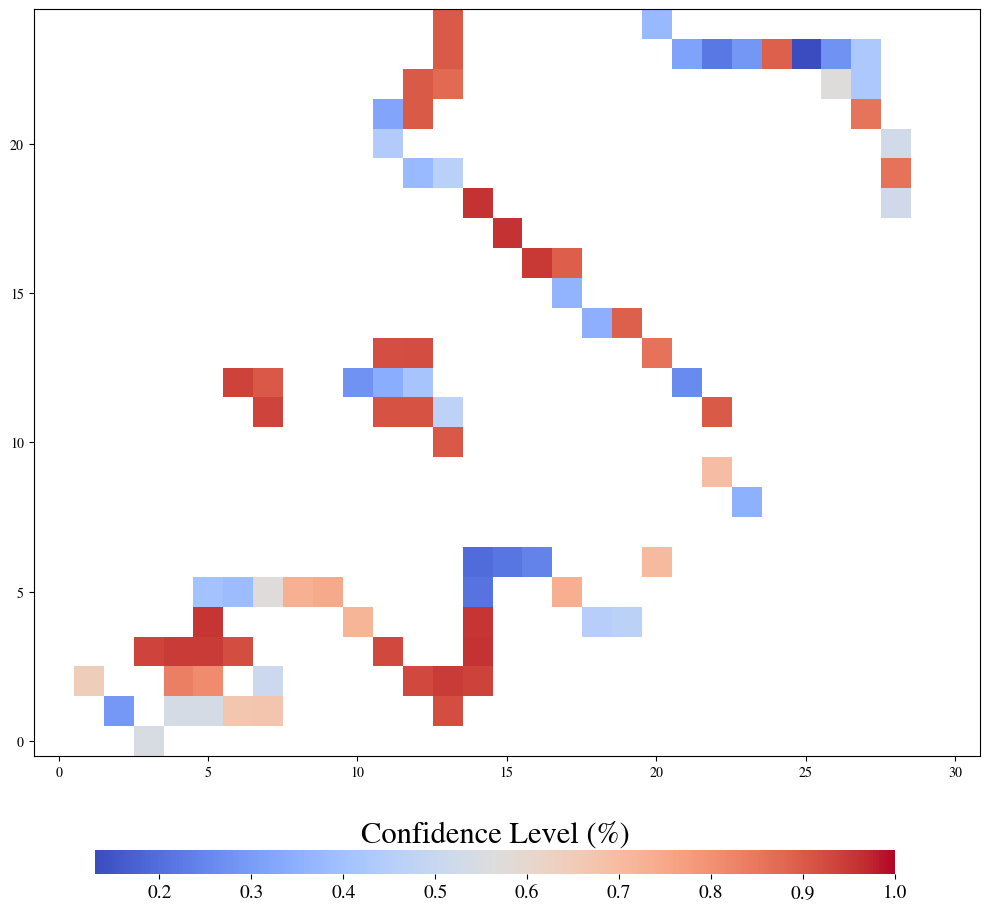

In [36]:
J_uc = model.conformalUncertainty(a_bins = 300)

J_mult = J_grid.copy().astype(float)
J_mult[J_mult == 0] = np.nan
J_plot = J_uc * J_mult
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
vmin = (J_uc).min()
im = plt.imshow((J_plot).T , cmap = "coolwarm", origin="lower", 
               interpolation="none", vmin = J_plot[~np.isnan(J_plot)].min(), vmax=1)
#ax.set_axis_off()
ax.axis("equal")
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, 0.8, 0.03])  # [left, bottom, width, height]
cbar_ax.set_title(r"Confidence Level (%)", fontsize=22, loc = "center")
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
num_ticks = 10  # Replace this with the number of ticks you want
cbar.locator = plt.MaxNLocator(num_ticks)
cbar.outline.set_visible(False)
plt.savefig("india_uncertainty_econ.pdf", bbox_inches="tight", dpi=300)

In [37]:
mask = np.ones(J_plot.shape, dtype=bool)
mask.T[20:30, 20:30] = False

print("10% Sign. " + str((J_plot[mask] > 0.90).sum()  / (J_plot[mask] > 0).sum()) + "5% Sign. " + str((J_plot[mask] > 0.95).sum()  / (J_plot[mask] > 0).sum()))


10% Sign. 0.3239436619718315% Sign. 0.07042253521126761


In [75]:
gdf['pings_share_norm'].describe()

count     980.000000
mean       37.016237
std       483.263073
min      -100.000000
25%       -56.677374
50%         0.000000
75%         0.000000
max      9200.000000
Name: pings_share_norm, dtype: float64

## Calculate Connectivity-Economy Linkage

In [43]:
model.grid_x.shape


(31, 25, 2)

In [36]:
u_mobile.shape

(122, 98)

In [40]:
Xplot

array([[ 0.        ,  0.        ,  0.        , 53.2951566 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 56.81448058,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 45.63944301,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0